In [1]:
import os
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torchvision.io as tvio
import matplotlib.pyplot as plt

In [2]:
# Ignore this - used so that matplotlib works.
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

In [3]:
# Creating a image dataset class for custom dataset.
class CustomImageDataset(Dataset):
    def __init__(self, root_dir, transform = None):
        self.root_dir = root_dir
        self.transform = transform
        self.class_to_idx = {class_name: idx for idx, class_name in enumerate(self._find_classes(root_dir))}
        self.samples = self._make_dataset(root_dir)
        self.classes = list(self.class_to_idx.keys())  # Define the classes attribute

    def __getitem__(self, idx):
        img_path, class_name = self.samples[idx]
        image = self.read_image_as_tensor(img_path) 
        # Apply transformations
        if self.transform:
            image = self.transform(image)
        return image, self.class_to_idx[class_name]  # Return the index of the class - tensors cannot be string.

    def _make_dataset(self, directory):
        images = []
        for target_class in self.class_to_idx.keys():
            target_dir = os.path.join(directory, target_class)
            if not os.path.isdir(target_dir):
                continue
            for root, _, fnames in sorted(os.walk(target_dir)):
                for fname in sorted(fnames):
                    path = os.path.join(root, fname)
                    item = (path, target_class)  
                    images.append(item)
        return images
        
    def read_image_as_tensor(self, img_path):
        image = tvio.read_image(img_path)
        if image.shape[0] == 4:  # PNG image sometimes has 4 channels.
            image = image[:3, :, :]  # Keep only the first 3 channels
        return image
    
    def _find_classes(self, directory):
        classes = [d.name for d in os.scandir(directory) if d.is_dir()]  # Each subfolder name is the class label.
        classes.sort()
        return classes
    
    def __len__(self):
        return len(self.samples)
    
    def __add__(self, other):
        concatenated_samples = self.samples + other.samples
        concatenated_classes = self.classes + other.classes
        concatenated_class_to_idx = {class_name: idx for idx, class_name in enumerate(concatenated_classes)}
        concatenated_dataset = CustomImageDataset.__new__(CustomImageDataset)
        concatenated_dataset.root_dir = self.root_dir  
        concatenated_dataset.transform = self.transform
        concatenated_dataset.samples = concatenated_samples
        concatenated_dataset.classes = concatenated_classes
        concatenated_dataset.class_to_idx = concatenated_class_to_idx
        return concatenated_dataset

In [4]:
# Defining transform with some data agumentation
aug_trans = transforms.Compose([
    transforms.RandomHorizontalFlip(),  
    transforms.RandomVerticalFlip(),  
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),  
    transforms.RandomRotation(10),  
    transforms.Lambda(lambda x: x / 255.),  # Scale to 0, 1
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize
    transforms.Resize((64, 64))
])

trans = transforms.Compose([
    transforms.Lambda(lambda x: x / 255.),  
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  
    transforms.Resize((64, 64))
])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


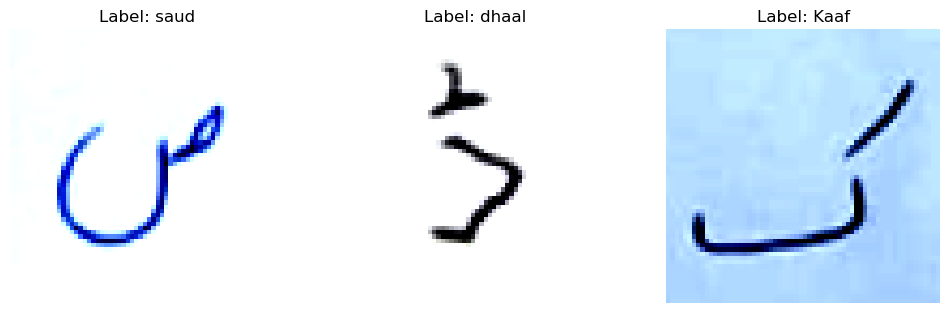

Number of samples = 3104


In [5]:
# Checking to see if dataset is properly read in.
image_folder = 'DL Cep Data'

normal = CustomImageDataset(root_dir=image_folder, transform = trans)
aug_dataset = CustomImageDataset(root_dir=image_folder, transform = aug_trans)

custom_dataset = normal + aug_dataset 
dataloader = DataLoader(custom_dataset, batch_size=4, shuffle=True)

for images, labels in dataloader:
    images_np = images.permute(0, 2, 3, 1).numpy() 
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    for i in range(3):
        class_index = labels[i].item() 
        class_name = custom_dataset.classes[class_index]  
        axes[i].imshow(images_np[i])
        axes[i].set_title(f"Label: {class_name}") 
        axes[i].axis('off')
    plt.show()
    break

print(f"Number of samples = {len(custom_dataset)}")

In [6]:
import torch
import torch.nn as nn
import torchvision.models as models
import torch.optim as optim

In [7]:
# Defining the test, load and validation datasets.
from torch.utils.data import random_split

train_size = int(0.7 * len(custom_dataset))  # 70% 
val_size = int(0.2 * len(custom_dataset))    # 20% 
test_size = len(custom_dataset) - train_size - val_size  # 10%

train_dataset, val_dataset, test_dataset = random_split(custom_dataset, [train_size, val_size, test_size])

train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True) # 32
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False)


In [8]:
class VGG16(nn.Module):
    def __init__(self, num_classes=10):
        super(VGG16, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU())
        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(), 
            nn.MaxPool2d(kernel_size=2, stride=2))  # Input image size = 64 x 64, now (32 x 32)
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU())
        self.layer4 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)) # (16 x 16)
        self.layer5 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU())
        self.layer6 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU())
        self.layer7 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)) # (8 x 8)
        self.layer8 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer9 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer10 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)) # (4 x 4)
        self.layer11 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer12 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer13 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)) # (2 x 2)
        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(512 * 2 * 2, 4096),  # (channels x h x w)
            nn.ReLU())
        self.fc1 = nn.Sequential(  
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU())
        self.fc2 = nn.Sequential(
            nn.Linear(4096, num_classes))

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = self.layer6(out)
        out = self.layer7(out)
        out = self.layer8(out)
        out = self.layer9(out)
        out = self.layer10(out)
        out = self.layer11(out)
        out = self.layer12(out)
        out = self.layer13(out)
        out = out.view(out.size(0), -1)  
        out = self.fc(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out


In [9]:
from tqdm import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # use gpu for faster training.
model = VGG16(num_classes=len(custom_dataset.classes)).to(device)  

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.005, weight_decay = 0.005, momentum = 0.9)  

model.train()

# Training
for epoch in range(15):
    running_loss = 0.0
    for images, labels in tqdm(train_dataloader, desc=f"Epoch {epoch+1}", unit="batch"):
        
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        
    print(f"Training Loss: {running_loss / len(train_dataloader)}")

    # Validation
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    avg_val_loss = test_loss / len(test_dataloader)
    accuracy = 100 * correct / total
    print(f'Validation Loss: {avg_val_loss}')
    print(f'Accuracy: {accuracy}%')
    model.train()
print('Finished Training')


Epoch 1: 100%|██████████████████████████████████████████████████████████████████████| 68/68 [01:35<00:00,  1.41s/batch]


Training Loss: 3.632432285477133
Validation Loss: 7.335020804405213
Accuracy: 5.967741935483871%


Epoch 2: 100%|██████████████████████████████████████████████████████████████████████| 68/68 [01:35<00:00,  1.40s/batch]


Training Loss: 2.0564058160080627
Validation Loss: 3.258224308490753
Accuracy: 44.67741935483871%


Epoch 3: 100%|██████████████████████████████████████████████████████████████████████| 68/68 [01:37<00:00,  1.43s/batch]


Training Loss: 1.2316672214690376
Validation Loss: 2.1110335767269133
Accuracy: 63.38709677419355%


Epoch 4: 100%|██████████████████████████████████████████████████████████████████████| 68/68 [01:37<00:00,  1.44s/batch]


Training Loss: 0.7648598599959823
Validation Loss: 2.9095137655735015
Accuracy: 51.12903225806452%


Epoch 5: 100%|██████████████████████████████████████████████████████████████████████| 68/68 [01:36<00:00,  1.42s/batch]


Training Loss: 0.5301018089932554
Validation Loss: 2.2949348747730256
Accuracy: 62.41935483870968%


Epoch 6: 100%|██████████████████████████████████████████████████████████████████████| 68/68 [01:36<00:00,  1.42s/batch]


Training Loss: 0.42653445373563204
Validation Loss: 3.5490097284317015
Accuracy: 52.74193548387097%


Epoch 7: 100%|██████████████████████████████████████████████████████████████████████| 68/68 [01:37<00:00,  1.43s/batch]


Training Loss: 0.29344284446800456
Validation Loss: 1.043962274491787
Accuracy: 82.74193548387096%


Epoch 8: 100%|██████████████████████████████████████████████████████████████████████| 68/68 [03:35<00:00,  3.18s/batch]


Training Loss: 0.23250648894292467
Validation Loss: 1.1809935696423053
Accuracy: 84.6774193548387%


Epoch 9: 100%|██████████████████████████████████████████████████████████████████████| 68/68 [03:27<00:00,  3.05s/batch]


Training Loss: 0.09763398015981212
Validation Loss: 0.646153599023819
Accuracy: 88.87096774193549%


Epoch 10: 100%|█████████████████████████████████████████████████████████████████████| 68/68 [01:36<00:00,  1.42s/batch]


Training Loss: 0.08253908147761489
Validation Loss: 0.942716097831726
Accuracy: 85.3225806451613%


Epoch 11: 100%|█████████████████████████████████████████████████████████████████████| 68/68 [01:37<00:00,  1.44s/batch]


Training Loss: 0.08834051092922249
Validation Loss: 1.0000353664159776
Accuracy: 85.3225806451613%


Epoch 12: 100%|█████████████████████████████████████████████████████████████████████| 68/68 [01:37<00:00,  1.43s/batch]


Training Loss: 0.07892466489883031
Validation Loss: 0.9533320248126984
Accuracy: 86.45161290322581%


Epoch 13: 100%|█████████████████████████████████████████████████████████████████████| 68/68 [01:37<00:00,  1.43s/batch]


Training Loss: 0.06989248094203718
Validation Loss: 0.34624739214777944
Accuracy: 94.6774193548387%


Epoch 14: 100%|█████████████████████████████████████████████████████████████████████| 68/68 [01:37<00:00,  1.44s/batch]


Training Loss: 0.05856195779051632
Validation Loss: 0.22466469295322894
Accuracy: 96.61290322580645%


Epoch 15: 100%|█████████████████████████████████████████████████████████████████████| 68/68 [01:37<00:00,  1.43s/batch]


Training Loss: 0.021485009484047836
Validation Loss: 0.27716084560379384
Accuracy: 96.61290322580645%
Finished Training


In [10]:
# Testing 
model.eval()
test_loss = 0.0
correct_test = 0
total_test = 0

with torch.no_grad():
    for images, labels in test_dataloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        _, predicted = outputs.max(1)
        total_test += labels.size(0)
        correct_test += predicted.eq(labels).sum().item()

avg_test_loss = test_loss / len(test_dataloader)
test_accuracy = 100 * correct_test / total_test
print(f'Test Loss: {avg_test_loss:.2f}')
print(f'Test Accuracy: {test_accuracy:.2f}%')


Test Loss: 0.13
Test Accuracy: 97.12%
